In [1]:
# backend.py

from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
from dotenv import load_dotenv
import sqlite3
import requests
import os
load_dotenv()

True

In [2]:
# -------------------
# 1. LLM
# -------------------
llm = ChatGoogleGenerativeAI(model = 'gemini-2.5-flash')

In [4]:
# 2. Tools
# -------------------
# Tools
search_tool = DuckDuckGoSearchRun(region="us-en")
@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}'"}
        
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}
    
@tool
def get_stock_price(symbol: str) -> dict:
    """
    Fetch latest stock price for a given symbol (e.g. 'AAPL', 'TSLA') 
    using Alpha Vantage with API key in the URL.
    """
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=C9PE94QUEW9VWGFM"
    r = requests.get(url)
    return r.json()

@tool
def get_weather_data(city: str) -> str:
    """
    This function fetches the current weather data for a given city
    """
    WEATHER_STACK_API = os.environ.get('WEATHER_STACK_API')
    url = f'https://api.weatherstack.com/current?access_key={WEATHER_STACK_API}&query={city}'
    response = requests.get(url)
    return response.json()

In [ ]:
# get_weather_data('chennai')

{'request': {'type': 'City',
  'query': 'Chennai, India',
  'language': 'en',
  'unit': 'm'},
 'location': {'name': 'Chennai',
  'country': 'India',
  'region': 'Tamil Nadu',
  'lat': '13.083',
  'lon': '80.283',
  'timezone_id': 'Asia/Kolkata',
  'localtime': '2025-11-06 22:39',
  'localtime_epoch': 1762468740,
  'utc_offset': '5.50'},
 'current': {'observation_time': '05:09 PM',
  'temperature': 26,
  'weather_code': 143,
  'weather_icons': ['https://cdn.worldweatheronline.com/images/wsymbols01_png_64/wsymbol_0006_mist.png'],
  'weather_descriptions': ['Mist'],
  'astro': {'sunrise': '06:04 AM',
   'sunset': '05:41 PM',
   'moonrise': '06:21 PM',
   'moonset': '06:37 AM',
   'moon_phase': 'Waning Gibbous',
   'moon_illumination': 100},
  'air_quality': {'co': '445.85',
   'no2': '10.85',
   'o3': '122',
   'so2': '5.25',
   'pm2_5': '19.35',
   'pm10': '19.95',
   'us-epa-index': '2',
   'gb-defra-index': '2'},
  'wind_speed': 11,
  'wind_degree': 72,
  'wind_dir': 'ENE',
  'pressure

In [5]:
tools = [search_tool, get_stock_price, calculator,get_weather_data]
llm_with_tools = llm.bind_tools(tools)


In [6]:
# -------------------
# 3. State
# -------------------
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [7]:
# -------------------
# 4. Nodes
# -------------------
def chat_node(state: ChatState):
    """LLM node that may answer or request a tool call."""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

tool_node = ToolNode(tools)

In [8]:
# -------------------
# 5. Checkpointer
# -------------------
conn = sqlite3.connect(database="test_chatbot.db", check_same_thread=False)
checkpointer = SqliteSaver(conn=conn)

In [10]:
# -------------------
# 6. Graph
# -------------------
graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat_node")

graph.add_conditional_edges("chat_node",tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile(checkpointer=checkpointer)

In [11]:
# -------------------
# 7. Helper
# -------------------
def retrieve_all_threads():
    all_threads = set()
    for checkpoint in checkpointer.list(None):
        all_threads.add(checkpoint.config["configurable"]["thread_id"])
    return list(all_threads)

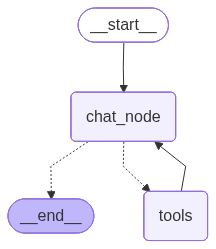

In [43]:
chatbot

In [81]:
CONFIG = {'configurable': {'thread_id': 'thread-5'}}

In [85]:
user_input = 'hi'

In [86]:
response = chatbot.invoke({'messages': [HumanMessage(content=user_input)]}, config=CONFIG)

In [87]:
response

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='3073299e-5475-4bcf-9816-6b3b04034096'),
  AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--966b5b51-7114-4c3e-a890-647098f5786d-0', usage_metadata={'input_tokens': 260, 'output_tokens': 9, 'total_tokens': 269, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='c9b6a9cc-cf0a-452d-b0aa-9c30893e6fd6'),
  AIMessage(content="Hello! I'm here to assist you. What can I do for you? ", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metad

In [34]:
response['messages'][-1].content[0]['text']

'Mumbai is the capital city of Maharashtra. The current temperature in Mumbai is 32 degrees Celsius, but it feels like 38 degrees Celsius. The sum of 5 and 3 is 8.'

In [29]:
from langchain_core.output_parsers import StrOutputParser

In [31]:
output_parser = StrOutputParser()

In [36]:
response

{'messages': [HumanMessage(content='capital city of maharastra and what is current temparature of it , what is the sum of 5,3', additional_kwargs={}, response_metadata={}, id='2ef92325-1de5-403b-87c2-b7a23795260c'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'duckduckgo_search', 'arguments': '{"query": "capital city of Maharashtra"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--60b816b6-a734-4012-ba65-85a76d315cc9-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'capital city of Maharashtra'}, 'id': '7ad60e6c-55fb-4192-800d-14d869865b72', 'type': 'tool_call'}], usage_metadata={'input_tokens': 284, 'output_tokens': 150, 'total_tokens': 434, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 130}}),
  ToolMessage(content="2 days 

In [39]:
from langchain_core.messages import ToolMessage,AIMessage

In [76]:
def ai_only_stream(user_input):
    for message_chun in  chatbot.stream(
        {"messages": [HumanMessage(content=user_input)]},
        config=CONFIG,
        stream_mode="messages",
    ):
        print(type(message_chun))
        if isinstance(message_chun,AIMessage):
            print(message_chun[0].content)
        

In [77]:
response = ai_only_stream(user_input=user_input)


<class 'tuple'>
<class 'tuple'>


In [61]:
response

In [48]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
  topic: str
  joke: str


def refine_topic(state: State):
    return {"topic": state["topic"] + " and cats"}


def generate_joke(state: State):
    return {"joke": f"This is a joke about {state['topic']}"}

graph = (
  StateGraph(State)
  .add_node(refine_topic)
  .add_node(generate_joke)
  .add_edge(START, "refine_topic")
  .add_edge("refine_topic", "generate_joke")
  .add_edge("generate_joke", END)
  .compile()
)

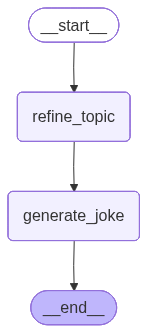

In [49]:
graph

In [50]:
for chunk in graph.stream(
    {"topic": "ice cream"},
    stream_mode="updates",  
):
    print(chunk)

{'refine_topic': {'topic': 'ice cream and cats'}}
{'generate_joke': {'joke': 'This is a joke about ice cream and cats'}}


In [96]:
from langchain_core.messages import AIMessage, AIMessageChunk, ToolMessage, HumanMessage

def get_final_ai_message(chatbot, user_input: str, CONFIG: dict):
    """
    Streams chatbot responses and collects both AIMessage and AIMessageChunk content,
    concatenating them into one final assistant output.
    Ignores tool messages and other intermediate chunks.
    """

    collected_text = ""

    for message_chunk, metadata in chatbot.stream(
        {"messages": [HumanMessage(content=user_input)]},
        config=CONFIG,
        stream_mode="messages",
    ):
        msg_type = type(message_chunk)

        # 🧩 TOOL MESSAGE (just info)
        if isinstance(message_chunk, ToolMessage):
            tool_name = getattr(message_chunk, "name", "tool")
            print(f"🔧 Running tool: {tool_name}...")
            continue

        # 🧠 AI MESSAGE (full structured response)
        if isinstance(message_chunk, AIMessage):
            content = message_chunk.content
            if isinstance(content, list):
                # e.g. [{'type': 'text', 'text': '...'}]
                text_parts = [
                    part.get("text", "")
                    for part in content
                    if isinstance(part, dict) and part.get("type") == "text"
                ]
                content = "".join(text_parts)
            collected_text += content.strip() + " "
            continue

        # 🧩 AI MESSAGE CHUNK (partial tokens during streaming)
        if isinstance(message_chunk, AIMessageChunk):
            content = getattr(message_chunk, "content", "")
            if content:
                collected_text += str(content).strip() + " "
            continue

        # Ignore everything else silently
        else:
            continue

    return collected_text.strip() if collected_text else None


In [99]:
get_final_ai_message(CONFIG=CONFIG,user_input='what is the sume of 2,3 and what is the capital of india and what is the temparature of mumbai take a example symbol and get the stock details for it is possible',chatbot=chatbot)

🔧 Running tool: calculator...
🔧 Running tool: duckduckgo_search...
🔧 Running tool: get_weather_data...
🔧 Running tool: get_stock_price...


"Here's the information you requested:\n\n*   **Sum of 2 and 3:** 5\n*   **Capital of India:** New Delhi\n*   **Temperature in Mumbai:** 31 degrees Celsius (feels like 35 degrees Celsius) with smoke and a wind speed of 8 km/h from the WSW. *   **Stock details for GOOG (Alphabet Inc. Class C):**\n    *   **Open:** 285.7350\n    *   **High:** 288.8100 *   **Low:** 281.6200\n    *   **Price:** 285.3400\n    *   **Volume:** 22478999 *   **Latest Trading Day:** 2025-11-06\n    *   **Previous Close:** 284.7500\n    *   **Change:** 0.590 0\n    *   **Change Percent:** 0.2072%"